In [1]:
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep
import xgboost as xgb
from cycler import cycler


# ML packages
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc, roc_curve
from scipy.integrate import trapezoid

# Module packages
from data_processing_BDT import process_data

gpustat.print_gpustat()

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu3.fnal.gov      Mon Nov 18 18:45:36 2024  555.42.06
[0] Tesla P100-PCIE-12GB | 44°C,   0 % |     2 / 12288 MB |


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

FILEPATHS_DICT = {
    'ggF HH': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GluGluToHH/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GluGluToHH/nominal/*"
    ],
    # 'VBF HH': [
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*"
    # ],
    'ttH': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/ttHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/ttHToGG/nominal/*"
    ],
    'non-res + single-H': [
        # non-Resonant #
        # GG + 3Jets
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GGJets/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GGJets/nominal/*",
        # GJet pT 20-40
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GJetPt20To40/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GJetPt20To40/nominal/*",
        # GJet pT 40-inf
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GJetPt40/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GJetPt40/nominal/*",
        # single-H #
        # ggF H
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GluGluHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GluGluHToGG/nominal/*",
        # VBF H
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VBFHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VBFHToGG/nominal/*",
        # VH
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VHToGG/nominal/*",
    ],
    # 'VH': [
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VHToGG/nominal/*"
    # ],
}

CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v1'
MOD_VALS = (5, 5)
VARS = 'nonres_and_ttH_vars'
# CURRENT_TIME = '2024-11-08_13-13-20'
CURRENT_TIME = '2024-11-16_13-10-23'
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}", CURRENT_TIME)
else:
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}")

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

SEED = 21
OPTIMIZE_SPACE = False
NUM_EPOCHS = 150

In [3]:
def training_weights(event_weights, labels, order=None, weighttype='rescaled'):
    if order is not None:
        sig_idx = -1
        for i, sample_name in enumerate(order):
            if re.search('ggF HH', sample_name) is not None:
                sig_idx = i
                break
    else:
        sig_idx = 0
    
    sig_sum = np.sum(event_weights[labels[:, sig_idx] == 1])
    bkg_sum = np.sum(event_weights[labels[:, sig_idx] == 0])
    
    sig_scale_factor = bkg_sum / sig_sum

    scaled_weights = np.where(
        labels[:, sig_idx] == 0, 
        event_weights,  # if bkg, do nothing
        event_weights * sig_scale_factor  # if sig, rescale to equal sum of all bkgs
    )

    abs_weights = np.abs(scaled_weights)

    if weighttype == 'abs':
        return abs_weights
    elif weighttype == 'rescaled':
        mean_weights = np.mean(scaled_weights)
        rescaled_weights = abs_weights / mean_weights
        return rescaled_weights

def xgb_labels(labels):
    label_i = np.sum(
        np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
        axis=1
    )

    return label_i

In [4]:
order = ['ggF HH', 'ttH', 'non-res + single-H']

(
    data_df_dict, data_test_df_dict, 
    data_hlf_dict, label_dict, 
    data_hlf_test_dict, label_test_dict, 
    hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    FILEPATHS_DICT, OUTPUT_DIRPATH, order=order, seed=SEED, mod_vals=MOD_VALS, k_fold_test=True,
    save=False if 'CURRENT_TIME' in globals() else True
)

xgb_label_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}
xgb_label_test_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}

weight_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}'], order=order)) for fold_idx in range(len(data_test_aux_dict))
}
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

Data HLF: (1563192, 48)
num ggF HH = 136530
num ttH = 277205
num non-res + single-H = 1149457
Data HLF test: (391785, 48)
num ggF HH = 34224
num ttH = 69297
num non-res + single-H = 288264
Data HLF: (1564171, 48)
num ggF HH = 136466
num ttH = 277452
num non-res + single-H = 1150253
Data HLF test: (390806, 48)
num ggF HH = 34288
num ttH = 69050
num non-res + single-H = 287468
Data HLF: (1563685, 48)
num ggF HH = 136638
num ttH = 276627
num non-res + single-H = 1150420
Data HLF test: (391292, 48)
num ggF HH = 34116
num ttH = 69875
num non-res + single-H = 287301
Data HLF: (1564419, 48)
num ggF HH = 136671
num ttH = 277054
num non-res + single-H = 1150694
Data HLF test: (390558, 48)
num ggF HH = 34083
num ttH = 69448
num non-res + single-H = 287027
Data HLF: (1564441, 48)
num ggF HH = 136711
num ttH = 277670
num non-res + single-H = 1150060
Data HLF test: (390536, 48)
num ggF HH = 34043
num ttH = 68832
num non-res + single-H = 287661


In [5]:
bdt_train_dict, bdt_val_dict, bdt_test_dict = {}, {}, {}

weights_plot_train, weights_plot_val = {}, {}
for fold_idx in range(len(data_df_dict)):
    if re.search('no_std', VARS) is not None:
        print('no standardization')
        train_val_data_dict = {key: value.to_numpy() for key, value in data_df_dict.items()}
        test_data_dict = {key: value.to_numpy() for key, value in data_test_df_dict.items()}
    else:
        train_val_data_dict = data_hlf_dict
        test_data_dict = data_hlf_test_dict
    (
        X_train, X_val, y_train, y_val, weight_train, weight_val
    ) = train_test_split(
        train_val_data_dict[f"fold_{fold_idx}"], xgb_label_dict[f"fold_{fold_idx}"], 
        weight_train_dict[f"fold_{fold_idx}"],
        test_size=0.2, random_state=21
    )
    weights_plot_train[f"fold_{fold_idx}"] = copy.deepcopy(weight_train)
    weights_plot_val[f"fold_{fold_idx}"] = copy.deepcopy(weight_val)

    bdt_train_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_train, label=y_train, 
        weight=weight_train,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    bdt_val_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_val, label=y_val, 
        weight=weight_val,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    
    bdt_test_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=test_data_dict[f"fold_{fold_idx}"], label=xgb_label_test_dict[f"fold_{fold_idx}"], 
        weight=np.abs(weight_test_dict[f"fold_{fold_idx}"]),
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )

    print(f"fold {fold_idx}")
    print(f"Num train: {len(y_train)} -> {sum(y_train == 0)} sig & {sum(y_train == 1)} ttH bkg & {sum(y_train == 2)} non-res + single-H bkg")
    print(f"Num val: {len(y_val)} -> {sum(y_val == 0)} sig & {sum(y_val == 1)} ttH bkg & {sum(y_val == 2)} non-res + single-H bkg")
    print(f"Num test: {len(label_test_dict[f'fold_{fold_idx}'])} -> {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([1, 0, 0]))[0]} sig & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 1, 0]))[1]} ttH bkg & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 1]))[2]} non-res + single-H bkg")
    print('='*60)

    

fold 0
Num train: 1250553 -> 109096 sig & 222178 ttH bkg & 919279 non-res + single-H bkg
Num val: 312639 -> 27434 sig & 55027 ttH bkg & 230178 non-res + single-H bkg
Num test: 391785 -> 34224 sig & 69297 ttH bkg & 288264 non-res + single-H bkg
fold 1
Num train: 1251336 -> 109298 sig & 221622 ttH bkg & 920416 non-res + single-H bkg
Num val: 312835 -> 27168 sig & 55830 ttH bkg & 229837 non-res + single-H bkg
Num test: 390806 -> 34288 sig & 69050 ttH bkg & 287468 non-res + single-H bkg
fold 2
Num train: 1250948 -> 109478 sig & 221207 ttH bkg & 920263 non-res + single-H bkg
Num val: 312737 -> 27160 sig & 55420 ttH bkg & 230157 non-res + single-H bkg
Num test: 391292 -> 34116 sig & 69875 ttH bkg & 287301 non-res + single-H bkg
fold 3
Num train: 1251535 -> 109266 sig & 221688 ttH bkg & 920581 non-res + single-H bkg
Num val: 312884 -> 27405 sig & 55366 ttH bkg & 230113 non-res + single-H bkg
Num test: 390558 -> 34083 sig & 69448 ttH bkg & 287027 non-res + single-H bkg
fold 4
Num train: 125155

In [ ]:
# https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier
# https://forecastegy.com/posts/xgboost-multiclass-classification-python/
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf


param = {}

# Booster parameters
param['eta']              = 0.03 # learning rate
param['max_depth']        = 5  # maximum depth of a tree
param['subsample']        = 0.6 # fraction of events to train tree on
param['colsample_bytree'] = 0.4 # fraction of features to train tree on
param['num_class']        = np.shape(label_dict['fold_0'])[1] # num classes for multi-class training

# Learning task parameters
param['objective']   = 'multi:softprob'   # objective function
param['eval_metric'] = 'merror'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'mlogloss')]

num_trees = 1000  # number of trees to make

In [7]:
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH, OLD_TIME = os.path.split(OUTPUT_DIRPATH)
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

evals_result_dict = {f"fold_{fold_idx}": dict() for fold_idx in range(len(bdt_train_dict))}
for fold_idx in range(len(bdt_train_dict)):
    print(f"fold {fold_idx}")
    # Train bdt
    evallist = [(bdt_train_dict[f"fold_{fold_idx}"], 'train'), (bdt_test_dict[f"fold_{fold_idx}"], 'test'), (bdt_val_dict[f"fold_{fold_idx}"], 'val')]
    booster = xgb.train(
        param, bdt_train_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
        evals=evallist, early_stopping_rounds=7, verbose_eval=25, evals_result=evals_result_dict[f"fold_{fold_idx}"]
    )

    booster.save_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
    # Print perf on test dataset
    print(booster.eval(bdt_test_dict[f"fold_{fold_idx}"], name='test', iteration=booster.best_iteration))
    print('='*100)

with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_eval_result.json'), 'w') as f:
    json.dump(evals_result_dict, f)

fold 0
[0]	train-merror:0.03927	train-mlogloss:1.03268	test-merror:0.04487	test-mlogloss:1.03566	val-merror:0.06129	val-mlogloss:1.03553
[25]	train-merror:0.01830	train-mlogloss:0.29885	test-merror:0.03043	test-mlogloss:0.32210	val-merror:0.04363	val-mlogloss:0.33655
[50]	train-merror:0.01388	train-mlogloss:0.11839	test-merror:0.02875	test-mlogloss:0.15152	val-merror:0.04275	val-mlogloss:0.17632
[75]	train-merror:0.01057	train-mlogloss:0.06103	test-merror:0.02762	test-mlogloss:0.10212	val-merror:0.04202	val-mlogloss:0.13252
[100]	train-merror:0.00771	train-mlogloss:0.04023	test-merror:0.02695	test-mlogloss:0.08662	val-merror:0.04163	val-mlogloss:0.11998


KeyboardInterrupt: 

In [ ]:
base_tpr = np.linspace(0, 1, 5000)  # copied from IN evaluate.py file
roc_baseline = np.zeros(
    (len(bdt_train_dict), len(base_tpr), len(order)), 
    dtype=float
)
area_baseline = np.zeros(
    (len(bdt_train_dict), len(order)), 
    dtype=float
)

BDT_perf = {
    sample_name: copy.deepcopy({
        'base_tpr': base_tpr,
        'class_order': copy.deepcopy(order),
        # test data #
        'preds': [],
        'fprs_density': copy.deepcopy(roc_baseline), 'thresholds_density': copy.deepcopy(roc_baseline), 'areas_density': copy.deepcopy(area_baseline),
        'fprs_weighted': copy.deepcopy(roc_baseline), 'thresholds_weighted': copy.deepcopy(roc_baseline), 'areas_weighted': copy.deepcopy(area_baseline),
        'fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # train data #
        'train_preds': [], 
        'train_fprs_density': copy.deepcopy(roc_baseline), 'train_thresholds_density': copy.deepcopy(roc_baseline), 'train_areas_density': copy.deepcopy(area_baseline),
        'train_fprs_weighted': copy.deepcopy(roc_baseline), 'train_thresholds_weighted': copy.deepcopy(roc_baseline), 'train_areas_weighted': copy.deepcopy(area_baseline),
        'train_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'train_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # val data #
        'val_preds': [],
        'val_fprs_density': copy.deepcopy(roc_baseline), 'val_thresholds_density': copy.deepcopy(roc_baseline), 'val_areas_density': copy.deepcopy(area_baseline),
        'val_fprs_weighted': copy.deepcopy(roc_baseline), 'val_thresholds_weighted': copy.deepcopy(roc_baseline), 'val_areas_weighted': copy.deepcopy(area_baseline),
        'val_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'val_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
    }) for sample_name in order
}

for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):
        booster = xgb.Booster(param)
        booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
        for pred_type, dataset in [
            ('train_', bdt_train_dict[f"fold_{fold_idx}"]),
            ('val_', bdt_val_dict[f"fold_{fold_idx}"]),
            ('', bdt_test_dict[f"fold_{fold_idx}"])
        ]:
            BDT_perf[sample_name][pred_type + 'preds'].append(
                booster.predict(
                    dataset, 
                    iteration_range=(0, booster.best_iteration+1)
                ).tolist()
            )

            for i, sample_name_ in enumerate(order):
                
                if sample_name_ == sample_name:
                    event_mask = dataset.get_label() > -1
                    pred_rescale = np.ones_like(event_mask)
                else:
                    event_mask = np.logical_or(dataset.get_label() == j, dataset.get_label() == i)
                    pred_rescale = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] + np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, i][event_mask]
                class_preds = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] / pred_rescale
                class_truths = np.where(dataset.get_label() == j, 1, 0)[event_mask]
                
                for roc_type in ['density', 'weighted']:

                    if roc_type == 'weighted':
                        if re.search('train', pred_type) is not None:
                            roc_weights = weights_plot_train[f"fold_{fold_idx}"][event_mask]
                        elif re.search('val', pred_type) is not None:
                            roc_weights = weights_plot_val[f"fold_{fold_idx}"][event_mask]
                        else:
                            roc_weights = weight_test_dict[f"fold_{fold_idx}"][event_mask]
                    else:
                        roc_weights = None

                    fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                    fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                    threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                    BDT_perf[sample_name][pred_type + 'fprs_' + roc_type][fold_idx][:, i] = fpr_bdt
                    BDT_perf[sample_name][pred_type + 'thresholds_' + roc_type][fold_idx][:, i] = threshold_bdt
                    BDT_perf[sample_name][pred_type + 'areas_' + roc_type][fold_idx][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for pred_type, dataset_dict in [
        ('train_', bdt_train_dict),
        ('val_', bdt_val_dict),
        ('', bdt_test_dict)
    ]:

        flat_preds = np.concatenate(BDT_perf[sample_name][f'{pred_type}preds'], axis=0)
        flat_truths = np.concatenate([dataset_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(dataset_dict))], axis=0)

        for i, sample_name_ in enumerate(order):
            
            if sample_name_ == sample_name:
                event_mask = flat_truths > -1
                pred_rescale = np.ones_like(event_mask)
            else:
                event_mask = np.logical_or(flat_truths == j, flat_truths == i)
                pred_rescale = flat_preds[:, j][event_mask] + flat_preds[:, i][event_mask]
            class_preds = flat_preds[:, j][event_mask] / pred_rescale
            class_truths = np.where(flat_truths == j, 1, 0)[event_mask]
            
            for roc_type in ['density', 'weighted']:

                if roc_type == 'weighted':
                    if re.search('train', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_train[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_train))], axis=0)[event_mask]
                    elif re.search('val', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_val[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_val))], axis=0)[event_mask]
                    else:
                        roc_weights = np.concatenate([weight_test_dict[f"fold_{fold_idx}"] for fold_idx in range(len(weight_test_dict))], axis=0)[event_mask]
                else:
                    roc_weights = None

                fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                BDT_perf[sample_name][pred_type + 'fprs_sum_' + roc_type][:, i] = fpr_bdt
                BDT_perf[sample_name][pred_type + 'thresholds_sum_' + roc_type][:, i] = threshold_bdt
                BDT_perf[sample_name][pred_type + 'areas_sum_' + roc_type][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for key in BDT_perf[sample_name].keys():
        if type(BDT_perf[sample_name][key]) is list:
            continue
        BDT_perf[sample_name][key] = BDT_perf[sample_name][key].tolist()

    # with h5py.File(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_ROC_fold{fold_idx}.h5"), "w") as out:
    #     out['FPR'] = fpr_bdt
    #     out['TPR'] = tpr_bdt
    #     out['Thresholds'] = threshold_bdt

with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'w') as f:
    json.dump(BDT_perf, f)

In [ ]:
# MC_NAMES_PRETTY = {
#     "GGJets": r"$\gamma\gamma+3j$",
#     "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
#     "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
#     "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
#     "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
#     "VHToGG": r"V$H\rightarrow\gamma\gamma$",
#     "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
#     "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
#     "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$"
#     # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
#     # Need to fill in pretty print for BSM samples #
# }
# LUMINOSITIES = {
#     '2022preEE': 7.9804, 
#     '2022postEE': 26.6717,
#     # Need to fill in lumis for other eras #
# }
# LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# # Dictionary of variables
# VARIABLES = {
#     # key: hist.axis axes for plotting #
#     # MET variables
#     'puppiMET_sumEt': hist.axis.Regular(40, 150., 2000, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
#     'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
#     'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
#     # jet-MET variables
#     'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
#     'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
#     # jet-photon variables
#     'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
#     # jet variables
#     # 'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
#     # 'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
#     'lead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
#     'lead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
#     'lead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
#     'sublead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
#     'sublead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
#     'sublead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
#     'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
#     'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
#     'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
#     # lepton variables
#     'n_leptons': hist.axis.Integer(0, 10, name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
#     'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
#     'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
#     'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
#     'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
#     'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
#     'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
#     # diphoton variables
#     'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
#     'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
#     'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
#     # angular (cos) variables
#     'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
#     'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False),
#     'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
#     'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
#     # jet-lepton variables
#     'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
#     'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
#     'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
#     'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
#     # dijet variables (must be blinded on data)
#     'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
#     # diphoton variables (must be blinded on data)
#     'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
# }
# # Dictionary of variables to do MC/Data comparison
# VARIABLES_STD = {
#     # key: hist.axis axes for plotting #
#     # MET variables
#     'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($\Sigma E_T$) [GeV]', growth=False, underflow=False, overflow=False), 
#     'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
#     'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
#     # jet-MET variables
#     'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
#     'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
#     # jet-photon variables
#     'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
#     # jet variables
#     'lead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
#     'sublead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
#     'lead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False), 
#     'sublead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\eta$', growth=False, underflow=False, overflow=False),
#     'lead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False), 
#     'sublead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\phi$', growth=False, underflow=False, overflow=False),
#     'n_jets': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
#     'chi_t0': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t0}^2$)', growth=False, underflow=False, overflow=False), 
#     'chi_t1': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t1}^2$)', growth=False, underflow=False, overflow=False), 
#     # lepton variables
#     'n_leptons': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
#     'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
#     'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
#     'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
#     'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
#     'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
#     'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
#     # diphoton variables
#     'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma$ ln($p_{T}$) [GeV]', growth=False, underflow=False, overflow=False),
#     'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
#     'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
#     # angular (cos) variables
#     'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
#     'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
#     'CosThetaStar_CS': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
#     'CosThetaStar_jj': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
#     # jet-lepton variables
#     'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
#     'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
#     'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
#     'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
#     # dijet variables (must be blinded on data)
#     'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'ln($M_{jj}$) [GeV]', growth=False, underflow=False, overflow=False),
#     # diphoton variables (must be blinded on data)
#     'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
# }

# def post_std_np_arrays(
#         data, data_test, fold, var_name, train_index=None, val_index=None
# ):
#     sig_mask = label_dict[f'fold_{fold}'] == 1
#     sig_test_mask = label_test_dict[f'fold_{fold}'] == 1
#     bkg_mask = label_dict[f'fold_{fold}'] == 0
#     bkg_test_mask = label_test_dict[f'fold_{fold}'] == 0
#     if train_index is not None and val_index is not None:
#         sig_train_mask = sig_mask & train_index 
#         sig_val_mask = sig_mask & val_index
#         bkg_train_mask = bkg_mask & train_index
#         bkg_val_mask = bkg_mask & val_index
#         if var_name in (high_level_fields_dict[f'fold_{fold}'] - set(input_hlf_vars_dict[f'fold_{fold}'])):
#             sig_train_np = data[data_list_index_map(var_name, data, sig_train_mask, n_pFields=N_PARTICLE_FIELDS)]
#             sig_val_np = data[data_list_index_map(var_name, data, sig_val_mask, n_pFields=N_PARTICLE_FIELDS)]
#             sig_test_np = data_test[data_list_index_map(var_name, data_test, sig_test_mask, n_pFields=N_PARTICLE_FIELDS)]
#             bkg_train_np = data[data_list_index_map(var_name, data, bkg_train_mask, n_pFields=N_PARTICLE_FIELDS)]
#             bkg_val_np = data[data_list_index_map(var_name, data, bkg_val_mask, n_pFields=N_PARTICLE_FIELDS)]
#             bkg_test_np = data_test[data_list_index_map(var_name, data_test, bkg_test_mask, n_pFields=N_PARTICLE_FIELDS)]
#         else:
#             index2 = hlf_vars_columns_dict[f'fold_{fold}'][var_name]
#             sig_train_np = data[sig_train_mask, index2]
#             sig_val_np = data[sig_val_mask, index2]
#             sig_test_np = data_test[sig_test_mask, index2]
#             bkg_train_np = data[bkg_train_mask, index2]
#             bkg_val_np = data[bkg_val_mask, index2]
#             bkg_test_np = data_test[bkg_test_mask, index2]

#         return (
#             sig_train_np, sig_val_np, sig_test_np, 
#             bkg_train_np, bkg_val_np, bkg_test_np
#         )
#     elif train_index is None and val_index is None:
#         if var_name in (high_level_fields_dict[f'fold_{fold}'] - set(input_hlf_vars_dict[f'fold_{fold}'])):
#             # index2, index3 = index_map[var_name]
#             sig_train_np = data[data_list_index_map(var_name, data, sig_mask, n_pFields=N_PARTICLE_FIELDS)]
#             sig_test_np = data_test[data_list_index_map(var_name, data_test, sig_test_mask, n_pFields=N_PARTICLE_FIELDS)]
#             bkg_train_np = data[data_list_index_map(var_name, data, bkg_mask, n_pFields=N_PARTICLE_FIELDS)]
#             bkg_test_np = data_test[data_list_index_map(var_name, data_test, bkg_test_mask, n_pFields=N_PARTICLE_FIELDS)]
#         else:
#             index2 = hlf_vars_columns_dict[f'fold_{fold}'][var_name]
#             sig_train_np = data[sig_mask, index2]
#             sig_test_np = data_test[sig_test_mask, index2]
#             bkg_train_np = data[bkg_mask, index2]
#             bkg_test_np = data_test[bkg_test_mask, index2]
#         return (
#             copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
#             copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
#         )
#     else:
#         raise Exception("Either both train_index and val_index must be 'None', or both should not be 'None'. You cannot mix and match.")

# def aux_np_arrays(var_name, score_cut, IN_full_eval_dict, fold):
#     sig_train_mask = (label_dict[f'fold_{fold}'] == 1) & (
#         np.exp(IN_full_eval_dict['train']['all_preds'][fold])[:, 1] > score_cut
#     )
#     sig_test_mask = (label_test_dict[f'fold_{fold}'] == 1) & (
#         np.exp(IN_full_eval_dict['test']['all_preds'][fold])[:, 1] > score_cut
#     )
#     bkg_train_mask = (label_dict[f'fold_{fold}'] == 0) & (
#         np.exp(IN_full_eval_dict['train']['all_preds'][fold])[:, 1] > score_cut
#     )
#     bkg_test_mask = (label_test_dict[f'fold_{fold}'] == 0) & (
#         np.exp(IN_full_eval_dict['test']['all_preds'][fold])[:, 1] > score_cut
#     )

#     sig_train_np = data_aux_dict[f'fold_{fold}'].loc[sig_train_mask, var_name].to_numpy()
#     sig_test_np = data_test_aux_dict[f'fold_{fold}'].loc[sig_test_mask, var_name].to_numpy()
#     bkg_train_np = data_aux_dict[f'fold_{fold}'].loc[bkg_train_mask, var_name].to_numpy()
#     bkg_test_np = data_test_aux_dict[f'fold_{fold}'].loc[bkg_test_mask, var_name].to_numpy()

#     return (
#         copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
#         copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
#     )

# def make_input_plot(
#     output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, 
#     plot_prefix='', plot_postfix='', alpha=0.8, linestyle=True
# ):
#     fig, ax = plt.subplots()
#     if linestyle:
#         if fold_idx is not None:
#             linestyles = ["solid", "dashed", "dotted", "solid", "dashed", "dotted"]
#         else:
#             linestyles = ["solid", "dotted", "solid", "dotted"]
#         linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
#         linestyles = linestyles[:len(hist_list)]
#     else:
#         linestyles = None
#     hep.histplot(
#         hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
#         linestyle=linestyles, label=labels, alpha=alpha
#     )
#     # Plotting niceties #
#     hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
#     hep.cms.text("Work in Progress", ax=ax)
#     # Plot legend properly
#     ax.legend(bbox_to_anchor=(1, 0.5))
#     # Make angular and chi^2 plots linear, otherwise log
#     if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
#         ax.set_yscale('log')
#     else:
#         ax.set_yscale('linear')
#     ax.set_yscale('linear')
#     # Save out the plot
#     if fold_idx is not None:
#         output_dir_ = os.path.join(output_dir, "fold")
#         if not os.path.exists(output_dir_):
#             os.makedirs(output_dir_)
#         plt.savefig(f'{output_dir_}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
#         plt.savefig(f'{output_dir_}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
#     else:
#         plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
#         plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')
#     plt.close()

# def plot_input_vars_after_score_cut(
#     IN_info, score_cut, destdir, fold, plot_prefix, plot_postfix='', method='std', 
#     weights={'sig': None, 'bkg': None}, all_sig=False, all_bkg=False,
#     mask=None
# ):
#     if method == 'std':
#         if mask is None:
#             mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
#         sig_mask = np.exp(
#             IN_info['mean_pred']
#         )[
#             np.logical_and(
#                 np.array(IN_info['mean_label']) == 1, mask
#             ),1
#         ] > score_cut
#         bkg_mask = np.exp(
#             IN_info['mean_pred']
#         )[
#             np.logical_and(
#                 np.array(IN_info['mean_label']) == 0, mask
#             ),1
#         ] > score_cut

#         for var_name in high_level_fields_dict[f'fold_{fold}']:
#             if var_name in {'event', 'puppiMET_eta'}:
#                 continue
#             sig_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==1) & mask, var_name]
#             sig_hist = hist.Hist(VARIABLES[var_name]).fill(
#                 var=sig_var.loc[sig_mask], 
#                 weight=weights['sig'][sig_mask] if weights['sig'] is not None else np.ones(np.sum(sig_mask))
#             )
#             bkg_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==0) & mask, var_name]
#             bkg_hist = hist.Hist(VARIABLES[var_name]).fill(
#                 var=bkg_var.loc[bkg_mask], 
#                 weight=weights['bkg'][bkg_mask] if weights['bkg'] is not None else np.ones(np.sum(bkg_mask))
#             )
#             make_input_plot(
#                 destdir, var_name, [sig_hist, bkg_hist], fold, plot_prefix=plot_prefix, 
#                 plot_postfix=plot_postfix+f'_ttHscore{score_cut}', labels=['HH signal', 'ttH background'], density=False if weights['sig'] is not None else True
#             )
#     elif method == 'round_robin':
#         if mask is None:
#             mask = np.ones(np.shape(IN_info['all_preds'][fold])[0], dtype=bool)
        
#         for var_name in high_level_fields_dict[f'fold_{fold}']:
#             if var_name in {'event', 'puppiMET_eta'}:
#                 continue
#             sig_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==1) & mask, var_name]
#             bkg_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==0) & mask, var_name]
#             sig_masks, bkg_masks = [], []
#             hists, labels = [], []
#             for cut in score_cut if score_cut is list else [score_cut]:
#                 sig_masks.append(np.exp(
#                     IN_info['all_preds'][fold]
#                 )[
#                     np.logical_and(
#                         np.array(IN_info['all_labels'][fold]) == 1, mask
#                     ),1
#                 ] > cut)
#                 bkg_masks.append(np.exp(
#                     IN_info['all_preds'][fold]
#                 )[
#                     np.logical_and(
#                         np.array(IN_info['all_labels'][fold]) == 0, mask
#                     ),1
#                 ] > cut)
                
#                 hists.append(hist.Hist(VARIABLES[var_name]).fill(
#                     var=sig_var.loc[sig_masks[-1]], 
#                     weight=weights['sig'][sig_masks[-1]] if weights['sig'] is not None else np.ones(np.sum(sig_masks[-1]))
#                 ))
#                 hists.append(hist.Hist(VARIABLES[var_name]).fill(
#                     var=bkg_var.loc[bkg_masks[-1]], 
#                     weight=weights['bkg'][bkg_masks[-1]] if weights['bkg'] is not None else np.ones(np.sum(bkg_masks[-1]))
#                 ))
#                 labels.extend([f'HH signal, ttH-score > {cut}', f'ttH background, ttH-score > {cut}'])
#             make_input_plot(
#                 destdir, var_name, hists, fold, plot_prefix=plot_prefix, 
#                 plot_postfix=plot_postfix+f'_ttHscore_scan', labels=labels, density=False if weights['sig'] is not None else True
#             )
#     elif method == 'arr':
#         if mask is None:
#             mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
#         for var_name in high_level_fields_dict[f'fold_{fold}']:
#             if var_name in {'event', 'puppiMET_eta'}:
#                 continue
#             sig_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==1) & mask, var_name]
#             bkg_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==0) & mask, var_name]
#             sig_masks, bkg_masks = [], []
#             hists, labels = [], []
#             for cut in score_cut:
#                 sig_masks.append(np.exp(
#                     IN_info['mean_pred']
#                 )[
#                     np.logical_and(
#                         np.array(IN_info['mean_label']) == 1, mask
#                     ),1
#                 ] > cut)
#                 bkg_masks.append(np.exp(
#                     IN_info['mean_pred']
#                 )[
#                     np.logical_and(
#                         np.array(IN_info['mean_label']) == 0, mask
#                     ),1
#                 ] > cut)
                
#                 hists.append(hist.Hist(VARIABLES[var_name]).fill(
#                     var=sig_var.loc[sig_masks[-1]], 
#                     weight=weights['sig'][sig_masks[-1]] if weights['sig'] is not None else np.ones(np.sum(sig_masks[-1]))
#                 ))
#                 hists.append(hist.Hist(VARIABLES[var_name]).fill(
#                     var=bkg_var.loc[bkg_masks[-1]], 
#                     weight=weights['bkg'][bkg_masks[-1]] if weights['bkg'] is not None else np.ones(np.sum(bkg_masks[-1]))
#                 ))
#                 labels.extend([f'HH signal, ttH-score > {cut}', f'ttH background, ttH-score > {cut}'])
#             make_input_plot(
#                 destdir, var_name, hists, fold, plot_prefix=plot_prefix, 
#                 plot_postfix=plot_postfix+f'_ttHscore_scan', labels=labels, density=False if weights['sig'] is not None else True
#             )
#     else:
#         raise Exception(f"Must used method 'std'. You used {method}.")

In [ ]:
def pad_list(list_of_lists):
    max_length = np.max([len(list_i) for list_i in list_of_lists])
    for list_i in list_of_lists:
        while len(list_i) < max_length:
            list_i.append(list_i[-1])

    return list_of_lists

def plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='png'):
    plot_prefix = plot_prefix + ('_' if plot_prefix != '' else '')
    plot_postfix = plot_postfix + ('_' if plot_postfix != '' else '')
    plot_name = plot_prefix + plot_name + plot_postfix + f'.{format}'

    plot_filepath = os.path.join(plot_dirpath, plot_name)
    return plot_filepath

def plot_train_val_losses(
    losses_arrs, labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', linestyles=None,
    losses_std_arrs=None
):
    plt.figure(figsize=(9,7))
    
    if type(losses_arrs[0]) is float:
        losses_arrs = [losses_arrs]
    if linestyles is None:
        linestyles = ['solid'] * len(losses_arrs)
    if labels is None:
        labels = [i for i in range(len(losses_arrs))]

    if losses_std_arrs is not None:
        for i in range(len(losses_std_arrs)):
            plt.fill_between(
                range(len(losses_std_arrs[i])), 
                losses_arrs[i]+losses_std_arrs[i], losses_arrs[i]-losses_std_arrs[i],
                alpha=0.7
            )

    for i in range(len(losses_arrs)):
        plt.plot(
            range(len(losses_arrs[i])), 
            losses_arrs[i], 
            label=f"{labels[i]} losses", linestyle=linestyles[i],
            alpha=0.7
        )
        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_rocs(
    fprs, tprs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', close=True, log=None
):
    plt.figure(figsize=(9,7))
    
    for fpr, tpr, label in zip(fprs, tprs, labels):
        linestyle = 'solid' if re.search('IN', label) is not None else ('dashed' if re.search('BDT', label) is not None else 'dotted')
        plt.plot(fpr, tpr, label=label, linestyle=linestyle)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    if log is not None and re.search('x', log) is not None:
        plt.xscale('log')
    elif log is not None and re.search('y', log) is not None:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    if close:
        plt.close()

def plot_output_scores(
    sigs_and_bkgs, order, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=50, weights=None, log=False
):
    plt.figure(figsize=(9,7))

    hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
    hists = {}
    for sample_name in order:
        hists[sample_name] = hist.Hist(hist_axis, storage='weight').fill(
            var=sigs_and_bkgs[sample_name], 
            weight=weights[sample_name] if weights is not None else np.ones_like(sigs_and_bkgs[sample_name])
        )
    hep.histplot(
        [hists[sample_name] for sample_name in order],
        yerr=(True if weights is not None else False),
        alpha=0.7, density=(False if weights is not None else True), histtype='step',
        label=[sample_name for sample_name in order]
    )

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    if log:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_s_over_root_b(
    sig, bkg, sample_name, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=50, weights={'sig': None, 'bkg': None},
    lines=None, lines_labels=None, line_colors=None
):
    plt.figure(figsize=(9,7))

    hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig))
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg))
    s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
    plt.plot(
        np.arange(0., 1., 1/bins), s_over_root_b_points, 
        label=f'{sample_name} - s/√b', alpha=0.8
    )

    if lines is not None:
        for i in range(len(lines)):
            plt.vlines(
                lines[i], 0, np.max(s_over_root_b_points), 
                label='s/√b'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                alpha=0.5, colors=line_colors[i]
            )
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    plt.ylabel('s/√b')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

In [ ]:
def optimize_cut_boundaries(sigs, bkgs, weights, bins=50):
    hist_list_fold = []
    cut_boundaries_fold = []
    cut_s_over_root_bs_fold = []
    sig_weights_fold = []
    bkg_weights_fold = []
    if len(np.shape(sigs)) == 1:
        sigs, bkgs = [sigs], [bkgs] 
    for sig, bkg in zip(sigs, bkgs):
        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'])
        hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

        fold_idx_cuts_bins_inclusive = []
        fold_idx_sig_weights = []
        fold_idx_bkg_weights = []
        fold_idx_prev_s_over_root_b = []
        prev_s_over_root_b = 0
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b):
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                fold_idx_sig_weights.append(
                    {
                        'value': np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_bkg_weights.append(
                    {
                        'value': np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_cuts_bins_inclusive.append(bins - i)
                fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        fold_idx_sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_cuts_bins_inclusive.append(0)
        fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
        fold_idx_score_cuts = [bin_i / bins for bin_i in fold_idx_cuts_bins_inclusive]
        cut_boundaries_fold.append(fold_idx_score_cuts)
        cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
        sig_weights_fold.append(fold_idx_sig_weights)
        bkg_weights_fold.append(fold_idx_bkg_weights)
    return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold

In [ ]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "losses")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

if 'evals_result_dict' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_eval_result.json"), 'r') as f:
        evals_result_dict = json.load(f)

# plot train/val/test losses
all_train, all_val, all_test = [], [], []
for fold_idx in range(len(evals_result_dict)):
    all_train.append(evals_result_dict[f"fold_{fold_idx}"]['train']['mlogloss'])
    all_val.append(evals_result_dict[f"fold_{fold_idx}"]['val']['mlogloss'])
    all_test.append(evals_result_dict[f"fold_{fold_idx}"]['test']['mlogloss'])

plot_train_val_losses(
    all_train + all_val, [f'train fold {i}' for i in range(len(all_train))]+[f'val fold {i}' for i in range(len(all_val))],
    'train_val_losses_vs_epoch', plot_dirpath, 
    linestyles=['solid']*len(all_train) + ['dashed']*len(all_val),
)
plot_train_val_losses(
    all_train + all_test, [f'train fold {i}' for i in range(len(all_train))]+[f'test fold {i}' for i in range(len(all_test))],
    'train_test_losses_vs_epoch', plot_dirpath,
    linestyles=['solid']*len(all_train) + ['dotted']*len(all_test),
)
avg_train, avg_val, avg_test = np.mean(pad_list(all_train), axis=0), np.mean(pad_list(all_val), axis=0), np.mean(pad_list(all_test), axis=0)
std_train, std_val, std_test = np.std(pad_list(all_train), axis=0), np.std(pad_list(all_val), axis=0), np.std(pad_list(all_test), axis=0)
plot_train_val_losses(
    [avg_train, avg_val, avg_test], ['train avg', 'val avg', 'test avg'],
    'train_val_test_avg_vs_epoch', plot_dirpath,
    losses_std_arrs=[std_train, std_val, std_test],
    linestyles=['solid', 'dashed', 'dotted'],
)

In [ ]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "ROCs")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

base_tpr = np.array(BDT_perf['ggF HH']['base_tpr'])

# plot ROCs
for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):

        for roc_type in ['density', 'weighted']:

            fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'][fold_idx])[:, i] for i in range(len(order))]
            tprs = [base_tpr for _ in range(len(order))]
            labels = [
                f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][fold_idx][i]:.4f}" 
                for i, sample_name_ in enumerate(order)
            ]

            plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_fold{fold_idx}", plot_dirpath)

    for roc_type in ['sum_density', 'sum_weighted']:

        fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'])[:, i] for i in range(len(order))]
        tprs = [base_tpr for _ in range(len(order))]
        labels = [
            f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][i]:.4f}" 
            for i, sample_name_ in enumerate(order)
        ]

        plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_sum", plot_dirpath)

In [ ]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot Output scores
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(bdt_train_dict)):
            
            sigs_and_bkgs = {
                sample_name__: np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }
            score_weights = {
                sample_name__: weight_test_dict[f"fold_{fold_idx}"][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }

            if sample_name_ != sample_name:
                event_j_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                pred_j_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_j_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_j_mask]
                event_i_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i
                pred_i_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_i_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_i_mask]

                for key in sigs_and_bkgs.keys():
                    if key == sample_name:
                        sigs_and_bkgs[key] = sigs_and_bkgs[key] / pred_j_rescale
                    elif key == sample_name_:
                        sigs_and_bkgs[key] = sigs_and_bkgs[key] / pred_i_rescale
                    else:
                        del sigs_and_bkgs[key]
                        del score_weights[key]

            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}outputScoreWeighted_testData_fold{fold_idx}", 
                plot_dirpath, weights=score_weights, log=True
            )
            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}outputScoreDensity_testData_fold{fold_idx}", 
                plot_dirpath
            )

        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
        flat_weights = np.concatenate([weight_test_dict[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

        sigs_and_bkgs = {
            sample_name__: flat_preds[:, j][flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        score_weights = {
            sample_name__: flat_weights[flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        
        if sample_name_ != sample_name:
            event_j_mask = flat_truths == j
            pred_j_rescale = flat_preds[:, j][event_j_mask] + flat_preds[:, i][event_j_mask]
            event_i_mask = flat_truths == i
            pred_i_rescale = flat_preds[event_i_mask] + flat_preds[event_i_mask]

            for key in sigs_and_bkgs.keys():
                if key == sample_name:
                    sigs_and_bkgs[key] = sigs_and_bkgs[key] / pred_j_rescale
                elif key == sample_name_:
                    sigs_and_bkgs[key] = sigs_and_bkgs[key] / pred_i_rescale
                else:
                    del sigs_and_bkgs[key]
                    del score_weights[key]
        
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}outputScoreWeighted_testData_sum", 
            plot_dirpath, weights=score_weights, log=True
        )
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}outputScoreDensity_testData_sum", 
            plot_dirpath
        )






















weights_sum, sigs_and_bkgs_sum = {}, {}
for fold_idx in range(len(bdt_train_dict)):
    weights_plot = {
        sample_name: weight_test_dict[f"fold_{fold_idx}"][xgb_label_test_dict[f"fold_{fold_idx}"] == i] 
        for i, sample_name in enumerate(order)
    }

    sigs_and_bkgs = {
        sample_name: np.array(BDT_perf[sample_name]['preds'])
    }
























    weights_plot = {
        sample_name: {
            sample_name_: weight_test_dict[f"fold_{fold_idx}"][xgb_label_test_dict[f"fold_{fold_idx}"] == i] for i, sample_name_ in enumerate(order)
        } for sample_name in order
    }

    sigs_and_bkgs = {
        sample_name: {
            sample_name_: np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][xgb_label_test_dict[f"fold_{fold_idx}"] == i] for i, sample_name_ in enumerate(order)
        } for j, sample_name in enumerate(order)
    }

    if fold_idx == 0:
        weights_sum = copy.deepcopy(weights_plot)
        sigs_and_bkgs_sum = copy.deepcopy(sigs_and_bkgs)
    else:
        for sample_name in order:
            for sample_name_ in order:
                weights_sum[sample_name][sample_name_] = np.concatenate((weights_sum[sample_name][sample_name_], weights_plot[sample_name][sample_name_]))
                sigs_and_bkgs_sum[sample_name][sample_name_] = np.concatenate((sigs_and_bkgs_sum[sample_name][sample_name_], sigs_and_bkgs[sample_name][sample_name_]))

    for sample_name in order:
        plot_output_scores(
            sigs_and_bkgs[sample_name], order, f"BDT_outputScoreWeighted_testData_fold{fold_idx}_{sample_name}", 
            plot_dirpath, weights=weights_plot[sample_name], log=True
        )
        plot_output_scores(
            sigs_and_bkgs[sample_name], order, f"BDT_outputScoreDensity_testData_fold{fold_idx}_{sample_name}", 
            plot_dirpath
        )
for sample_name in order:
    plot_output_scores(
        sigs_and_bkgs_sum[sample_name], order, f"BDT_outputScoreWeighted_testData_sum_{sample_name}", 
        plot_dirpath, weights=weights_sum[sample_name], log=True
    )
    plot_output_scores(
        sigs_and_bkgs_sum[sample_name], order, f"BDT_outputScoreDensity_testData_sum_{sample_name}", 
        plot_dirpath
    )

/tmp/ipykernel_3674264/3615860554.py:134: RuntimeWarning: invalid value encountered in sqrt
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_3674264/3615860554.py:134: RuntimeWarning: divide by zero encountered in divide
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_3674264/4090294250.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  if prev_s_over_root_b < (s / sqrt_b):
/tmp/ipykernel_3674264/4090294250.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  prev_s_over_root_b = s / sqrt_b
/tmp/ipykernel_3674264/3615860554.py:134: RuntimeWarning: invalid value encountered in sqrt
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_3674264/3615860554.py:134: RuntimeWarning: divide by zero encountered in divide
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.

IndexError: list index out of range

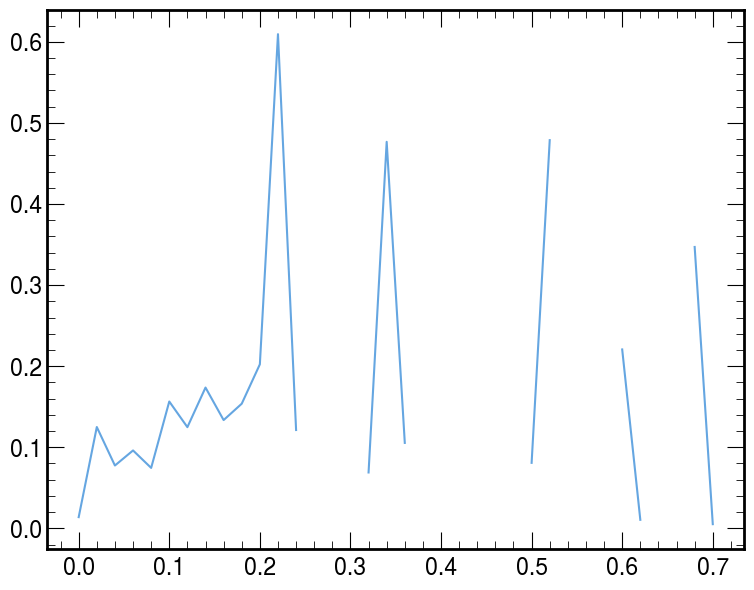

In [ ]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot s/√b curves
weights_sum_sob, sigs_and_bkgs_sum_sob = {}, {}
for fold_idx in range(len(bdt_train_dict)):
    weights_plot = {
        sample_name: {
            'sig': weight_test_dict[f"fold_{fold_idx}"][xgb_label_test_dict[f"fold_{fold_idx}"] == j],
            'bkg': weight_test_dict[f"fold_{fold_idx}"][xgb_label_test_dict[f"fold_{fold_idx}"] != j],
        } for j, sample_name in enumerate(order)
    }

    sigs_and_bkgs = {
        sample_name: {
            'sig': np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][xgb_label_test_dict[f"fold_{fold_idx}"] == j],
            'bkg': np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][xgb_label_test_dict[f"fold_{fold_idx}"] != j],
        } for j, sample_name in enumerate(order)
    }

    if fold_idx == 0:
        weights_sum = copy.deepcopy(weights_plot)
        sigs_and_bkgs_sum = copy.deepcopy(sigs_and_bkgs)
    else:
        for sample_name in order:
            for sample_name_ in weights_plot[sample_name].keys():
                weights_sum[sample_name][sample_name_] = np.concatenate((weights_sum[sample_name][sample_name_], weights_plot[sample_name][sample_name_]))
                sigs_and_bkgs_sum[sample_name][sample_name_] = np.concatenate((sigs_and_bkgs_sum[sample_name][sample_name_], sigs_and_bkgs[sample_name][sample_name_]))

    for sample_name in order:
        plot_s_over_root_b(
            sigs_and_bkgs[sample_name]['sig'], sigs_and_bkgs[sample_name]['bkg'], sample_name, f"BDT_sOverRootb_testData_fold{fold_idx}_{sample_name}", 
            plot_dirpath, weights=weights_plot[sample_name]
        )

        (
            cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
        ) = optimize_cut_boundaries(
            sigs_and_bkgs[sample_name]['sig'], sigs_and_bkgs[sample_name]['bkg'], 
            weights_plot[sample_name]
        )

        BDT_cut_labels = [
            f"s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.4f}, s={sig_weights_fold[0][cut_idx]['value']:.4f}±{sig_weights_fold[0][cut_idx]['w2']:.4f}, b={bkg_weights_fold[0][cut_idx]['value']:.4f}±{bkg_weights_fold[0][cut_idx]['w2']:.4f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
        ]
        line_labels = BDT_cut_labels
        lines = cut_boundaries_fold[0]
        line_colors = cmap_petroff10

        plot_s_over_root_b(
            sigs_and_bkgs[sample_name]['sig'], sigs_and_bkgs[sample_name]['bkg'], sample_name, 
            f"BDT_sOverRootb_withCuts_testData_fold{fold_idx}_{sample_name}", plot_dirpath, 
            weights=weights_plot[sample_name],
            lines=lines, lines_labels=line_labels, line_colors=line_colors
        )
for sample_name in order:
    plot_s_over_root_b(
        sigs_and_bkgs_sum[sample_name]['sig'], sigs_and_bkgs_sum[sample_name]['bkg'], sample_name, f"BDT_sOverRootb_testData_sum_{sample_name}", 
        plot_dirpath, weights=weights_sum[sample_name]
    )

    (
        cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
    ) = optimize_cut_boundaries(
        sigs_and_bkgs_sum[sample_name]['sig'], sigs_and_bkgs_sum[sample_name]['bkg'], 
        weights_sum[sample_name]
    )

    BDT_cut_labels = [
        f"s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.4f}, s={sig_weights_fold[0][cut_idx]['value']:.4f}±{sig_weights_fold[0][cut_idx]['w2']:.4f}, b={bkg_weights_fold[0][cut_idx]['value']:.4f}±{bkg_weights_fold[0][cut_idx]['w2']:.4f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
    ]
    line_labels = BDT_cut_labels
    lines = cut_boundaries_fold[0]
    line_colors = cmap_petroff10

    plot_s_over_root_b(
        sigs_and_bkgs_sum[sample_name]['sig'], sigs_and_bkgs_sum[sample_name]['bkg'], sample_name, 
        f"BDT_sOverRootb_withCuts_testData_sum_{sample_name}", plot_dirpath, 
        weights=weights_sum[sample_name],
        lines=lines, lines_labels=line_labels, line_colors=line_colors
    )


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

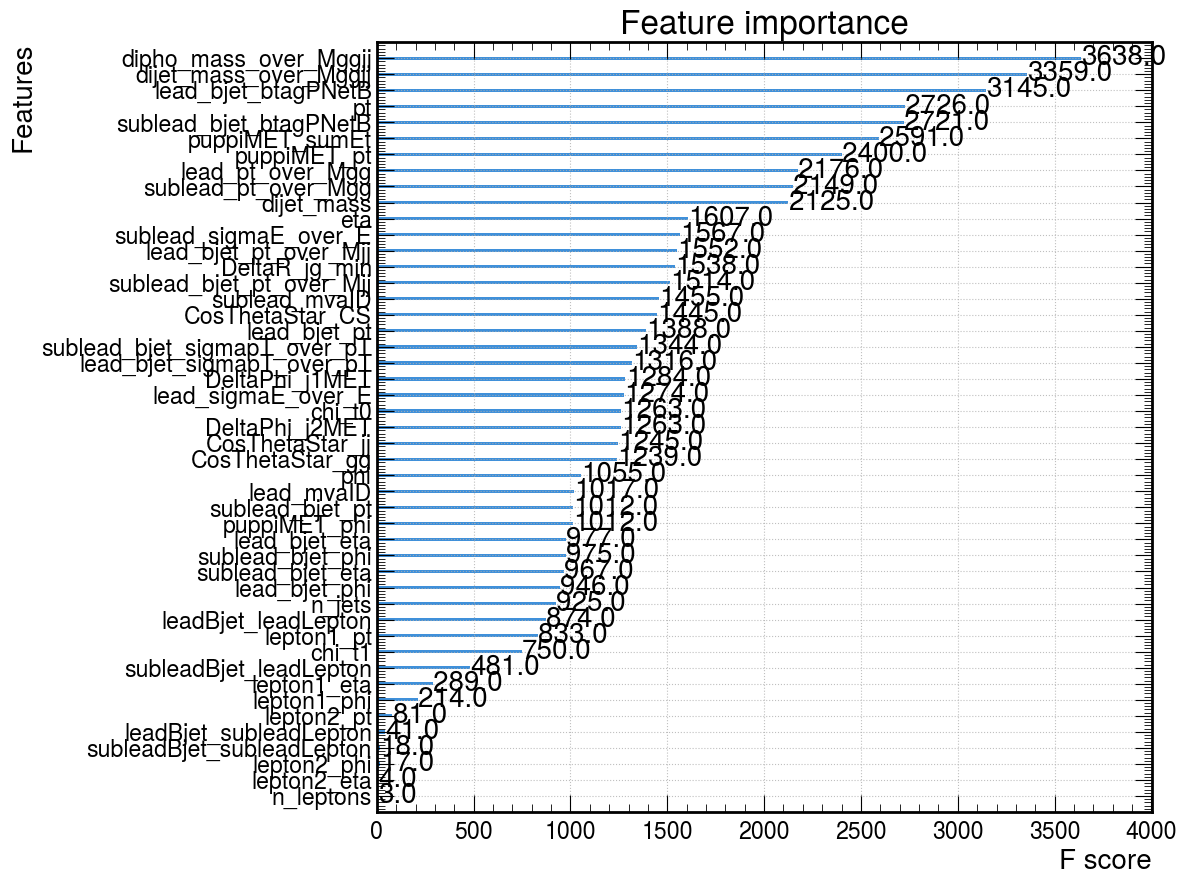

In [ ]:
xgb.plot_importance(booster)

In [ ]:
import graphviz
xgb.to_graphviz(booster)